In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import re
import pickle
from tqdm import tqdm
import os
# from google.colab import files
# from google.colab import drive
import io
from prettytable import PrettyTable
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix


In [ ]:
import numpy as np

def confusion_matrix_to_accuraccies(confusion_matrix):

    confusion_matrix = confusion_matrix.astype(float)
    # sum(0) <- predicted sum(1) ground truth

    total = np.sum(confusion_matrix)
    n_classes, _ = confusion_matrix.shape
    overall_accuracy = np.sum(np.diag(confusion_matrix)) / total

    # calculate Cohen Kappa (https://en.wikipedia.org/wiki/Cohen%27s_kappa)
    N = total
    p0 = np.sum(np.diag(confusion_matrix)) / N
    pc = np.sum(np.sum(confusion_matrix, axis=0) * np.sum(confusion_matrix, axis=1)) / N ** 2
    kappa = (p0 - pc) / (1 - pc)

    recall = np.diag(confusion_matrix) / (np.sum(confusion_matrix, axis=1) + 1e-12)
    precision = np.diag(confusion_matrix) / (np.sum(confusion_matrix, axis=0) + 1e-12)
    f1 = (2 * precision * recall) / ((precision + recall) + 1e-12)

    # Per class accuracy
    cl_acc = np.diag(confusion_matrix) / (confusion_matrix.sum(1) + 1e-12)

    return overall_accuracy, kappa, precision, recall, f1, cl_acc

class ClassMetric(object):
    def __init__(self, num_classes=2, ignore_index=0):
        self.num_classes = num_classes
        _range = -0.5, num_classes - 0.5
        self.range = np.array((_range, _range), dtype=np.int64)
        self.ignore_index = ignore_index
        self.hist = np.zeros((num_classes, num_classes), dtype=np.float64)

        self.store = dict()

        self.earliness_record = list()

    def _update(self, o, t):
        t = t.flatten()
        o = o.flatten()
        # confusion matrix
        n, _, _ = np.histogram2d(t, o, bins=self.num_classes, range=self.range)
        self.hist += n

    def add(self, stats):
        for key, value in stats.items():

            value = value.data.cpu().numpy()

            if key in self.store.keys():
                self.store[key].append(value)
            else:
                self.store[key] = list([value])

        return dict((k, np.stack(v).mean()) for k, v in self.store.items())

    def update_confmat(self, target, output):
        self._update(output, target)
        return self.accuracy()

    def update_earliness(self,earliness):
        self.earliness_record.append(earliness)
        return np.hstack(self.earliness_record).mean()

    def accuracy(self):
        """
        https: // en.wikipedia.org / wiki / Confusion_matrix
        Calculates over all accuracy and per class classification metrics from confusion matrix
        :param confusion_matrix numpy array [n_classes, n_classes] rows True Classes, columns predicted classes:
        :return overall accuracy
                and per class metrics as list[n_classes]:
        """
        confusion_matrix = self.hist

        if type(confusion_matrix) == list:
            confusion_matrix = np.array(confusion_matrix)

        overall_accuracy, kappa, precision, recall, f1, cl_acc = confusion_matrix_to_accuraccies(confusion_matrix)

        return dict(
            overall_accuracy=overall_accuracy,
            kappa=kappa,
            precision=precision,
            recall=recall,
            f1=f1,
            accuracy=cl_acc
        )


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **load the data from csv**

In [ ]:
data=pd.read_csv("/content/drive/My Drive/time_series_EVI-corr.csv")

In [ ]:
print(data['ID'].value_counts())

Permanent grasslands      95754
Heathlands                74283
Wheat                     31911
Rapeseed                  16065
Barley                    14594
Maize                      9128
Temporary grasslands       3388
Sunflower                  2682
Other cereals              2065
Protein crops              1182
Fallows                    1029
Vineyards                   363
Rice                        309
Other oilseeds              275
Vegetables and Flowers      136
Orchards                    121
Seeds                       113
Fiber plants                 83
Seed legumes                 66
Olive trees                   1
Name: ID, dtype: int64


In [ ]:
labels = data['ID'].unique().tolist()
labels

['Permanent grasslands',
 'Maize',
 'Wheat',
 'Rapeseed',
 'Temporary grasslands',
 'Heathlands',
 'Barley',
 'Other cereals',
 'Protein crops',
 'Other oilseeds',
 'Sunflower',
 'Fallows',
 'Vegetables and Flowers',
 'Fiber plants',
 'Vineyards',
 'Rice',
 'Orchards',
 'Seeds',
 'Seed legumes',
 'Olive trees']

In [ ]:
data.dropna(inplace=True)

In [ ]:
print("Number of data points in train data",data.shape)
print('-'*50)
print("The attributes of data :",data.columns.values)
data.head()

Number of data points in train data (209299, 47)
--------------------------------------------------
The attributes of data : ['ID' 'EVI_2006_001' 'EVI_2006_009' 'EVI_2006_017' 'EVI_2006_025'
 'EVI_2006_033' 'EVI_2006_041' 'EVI_2006_049' 'EVI_2006_057'
 'EVI_2006_065' 'EVI_2006_073' 'EVI_2006_081' 'EVI_2006_089'
 'EVI_2006_097' 'EVI_2006_105' 'EVI_2006_113' 'EVI_2006_121'
 'EVI_2006_129' 'EVI_2006_137' 'EVI_2006_145' 'EVI_2006_153'
 'EVI_2006_161' 'EVI_2006_169' 'EVI_2006_177' 'EVI_2006_185'
 'EVI_2006_193' 'EVI_2006_201' 'EVI_2006_209' 'EVI_2006_217'
 'EVI_2006_225' 'EVI_2006_233' 'EVI_2006_241' 'EVI_2006_249'
 'EVI_2006_257' 'EVI_2006_265' 'EVI_2006_273' 'EVI_2006_281'
 'EVI_2006_289' 'EVI_2006_297' 'EVI_2006_305' 'EVI_2006_313'
 'EVI_2006_321' 'EVI_2006_329' 'EVI_2006_337' 'EVI_2006_345'
 'EVI_2006_353' 'EVI_2006_361']


,ID,EVI_2006_001,EVI_2006_009,EVI_2006_017,EVI_2006_025,EVI_2006_033,EVI_2006_041,EVI_2006_049,EVI_2006_057,EVI_2006_065,EVI_2006_073,EVI_2006_081,EVI_2006_089,EVI_2006_097,EVI_2006_105,EVI_2006_113,EVI_2006_121,EVI_2006_129,EVI_2006_137,EVI_2006_145,EVI_2006_153,EVI_2006_161,EVI_2006_169,EVI_2006_177,EVI_2006_185,EVI_2006_193,EVI_2006_201,EVI_2006_209,EVI_2006_217,EVI_2006_225,EVI_2006_233,EVI_2006_241,EVI_2006_249,EVI_2006_257,EVI_2006_265,EVI_2006_273,EVI_2006_281,EVI_2006_289,EVI_2006_297,EVI_2006_305,EVI_2006_313,EVI_2006_321,EVI_2006_329,EVI_2006_337,EVI_2006_345,EVI_2006_353,EVI_2006_361
0,Permanent grasslands,0.05,0.08,0.05,0.02,0.12,0.05,0.09,0.06,0.07,0.04,0.09,0.09,0.23,0.28,0.28,0.34,0.68,0.69,0.69,0.63,0.70,0.58,0.56,0.63,0.57,0.55,0.58,0.53,0.52,0.54,0.58,0.49,0.53,0.49,0.45,0.44,0.33,0.34,0.33,0.21,0.29,0.22,0.11,0.12,0.25,0.28
1,Permanent grasslands,0.00,0.03,-0.02,-0.04,0.10,0.01,0.00,0.07,0.02,0.05,0.10,0.22,0.25,0.34,0.36,0.45,0.69,0.63,0.63,0.56,0.61,0.53,0.44,0.51,0.46,0.50,0.48,0.50,0.44,0.49,0.50,0.51,0.53,0.54,0.42,0.50,0.37,0.42,0.37,0.30,0.36,0.34,0.06,0.12,0.36,0.31
2,Maize,0.14,0.28,0.16,0.27,0.29,0.15,0.14,0.16,0.16,0.17,0.42,0.17,0.16,0.23,0.39,0.32,0.40,0.33,0.18,0.20,0.31,0.31,0.43,0.37,0.62,0.66,0.72,0.60,0.69,0.66,0.66,0.65,0.66,0.57,0.53,0.54,0.40,0.33,0.22,0.23,0.22,0.31,0.20,0.20,0.21,0.15
3,Maize,0.14,0.28,0.16,0.27,0.29,0.15,0.14,0.16,0.16,0.17,0.42,0.17,0.16,0.23,0.39,0.32,0.40,0.33,0.18,0.20,0.31,0.31,0.43,0.37,0.62,0.66,0.72,0.60,0.69,0.66,0.66,0.65,0.66,0.57,0.53,0.54,0.40,0.33,0.22,0.23,0.22,0.31,0.20,0.20,0.21,0.15
4,Permanent grasslands,0.01,0.02,0.01,-0.06,0.02,-0.01,0.02,0.00,0.00,0.02,0.10,0.23,0.27,0.37,0.33,0.41,0.72,0.59,0.59,0.54,0.64,0.47,0.46,0.48,0.48,0.50,0.56,0.47,0.46,0.51,0.50,0.49,0.52,0.57,0.42,0.51,0.43,0.42,0.44,0.37,0.36,0.41,0.10,0.35,0.38,0.29


In [ ]:
Type={}
for i,j in enumerate(data.ID.unique()):
    Type[j]=i
print(Type)   
crop=[]
for i in data.ID:
    crop.append(Type[i])
data['ID']=crop    


{'Permanent grasslands': 0, 'Maize': 1, 'Wheat': 2, 'Rapeseed': 3, 'Temporary grasslands': 4, 'Heathlands': 5, 'Barley': 6, 'Other cereals': 7, 'Protein crops': 8, 'Other oilseeds': 9, 'Sunflower': 10, 'Fallows': 11, 'Vegetables and Flowers': 12, 'Fiber plants': 13, 'Vineyards': 14, 'Rice': 15, 'Orchards': 16, 'Seeds': 17, 'Seed legumes': 18, 'Olive trees': 19}


In [ ]:
data.head()

,ID,EVI_2006_001,EVI_2006_009,EVI_2006_017,EVI_2006_025,EVI_2006_033,EVI_2006_041,EVI_2006_049,EVI_2006_057,EVI_2006_065,EVI_2006_073,EVI_2006_081,EVI_2006_089,EVI_2006_097,EVI_2006_105,EVI_2006_113,EVI_2006_121,EVI_2006_129,EVI_2006_137,EVI_2006_145,EVI_2006_153,EVI_2006_161,EVI_2006_169,EVI_2006_177,EVI_2006_185,EVI_2006_193,EVI_2006_201,EVI_2006_209,EVI_2006_217,EVI_2006_225,EVI_2006_233,EVI_2006_241,EVI_2006_249,EVI_2006_257,EVI_2006_265,EVI_2006_273,EVI_2006_281,EVI_2006_289,EVI_2006_297,EVI_2006_305,EVI_2006_313,EVI_2006_321,EVI_2006_329,EVI_2006_337,EVI_2006_345,EVI_2006_353,EVI_2006_361
0,0,0.05,0.08,0.05,0.02,0.12,0.05,0.09,0.06,0.07,0.04,0.09,0.09,0.23,0.28,0.28,0.34,0.68,0.69,0.69,0.63,0.70,0.58,0.56,0.63,0.57,0.55,0.58,0.53,0.52,0.54,0.58,0.49,0.53,0.49,0.45,0.44,0.33,0.34,0.33,0.21,0.29,0.22,0.11,0.12,0.25,0.28
1,0,0.00,0.03,-0.02,-0.04,0.10,0.01,0.00,0.07,0.02,0.05,0.10,0.22,0.25,0.34,0.36,0.45,0.69,0.63,0.63,0.56,0.61,0.53,0.44,0.51,0.46,0.50,0.48,0.50,0.44,0.49,0.50,0.51,0.53,0.54,0.42,0.50,0.37,0.42,0.37,0.30,0.36,0.34,0.06,0.12,0.36,0.31
2,1,0.14,0.28,0.16,0.27,0.29,0.15,0.14,0.16,0.16,0.17,0.42,0.17,0.16,0.23,0.39,0.32,0.40,0.33,0.18,0.20,0.31,0.31,0.43,0.37,0.62,0.66,0.72,0.60,0.69,0.66,0.66,0.65,0.66,0.57,0.53,0.54,0.40,0.33,0.22,0.23,0.22,0.31,0.20,0.20,0.21,0.15
3,1,0.14,0.28,0.16,0.27,0.29,0.15,0.14,0.16,0.16,0.17,0.42,0.17,0.16,0.23,0.39,0.32,0.40,0.33,0.18,0.20,0.31,0.31,0.43,0.37,0.62,0.66,0.72,0.60,0.69,0.66,0.66,0.65,0.66,0.57,0.53,0.54,0.40,0.33,0.22,0.23,0.22,0.31,0.20,0.20,0.21,0.15
4,0,0.01,0.02,0.01,-0.06,0.02,-0.01,0.02,0.00,0.00,0.02,0.10,0.23,0.27,0.37,0.33,0.41,0.72,0.59,0.59,0.54,0.64,0.47,0.46,0.48,0.48,0.50,0.56,0.47,0.46,0.51,0.50,0.49,0.52,0.57,0.42,0.51,0.43,0.42,0.44,0.37,0.36,0.41,0.10,0.35,0.38,0.29


In [ ]:
# cols=list(data.columns.unique())
# for col in cols[:-1]:
#     sns.set_style("whitegrid")
#     sns.boxplot('ID',col, data=data)
#     plt.xlabel("ID") # Set text for the x axis
#     plt.ylabel(col)# Set text for y axis
#     plt.show()

# Splitiing the data into train, dev and validation

In [ ]:
data=shuffle(data)
y=data['ID']
X=data.drop(['ID'],axis=1)
print("The shape of X:",X.shape)
print("The shape of y:",y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)
X_train,X_cv,y_train,y_cv=train_test_split(X_train,y_train,test_size=0.20, random_state=1)
print("The shape of train data:",'X:',X_train.shape,'y:',y_train.shape)
print("The shape of test data:",'X:',X_test.shape,'y:',y_test.shape)
print("The shape of cv data:",'X:',X_cv.shape,'y:',y_cv.shape)

The shape of X: (209299, 46)
The shape of y: (209299,)
The shape of train data: X: (100463, 46) y: (100463,)
The shape of test data: X: (83720, 46) y: (83720,)
The shape of cv data: X: (25116, 46) y: (25116,)


In [ ]:
# scaler=MinMaxScaler()
# scaler.fit(X_train)
# X_train=scaler.transform(X_train)
# X_test=scaler.transform(X_test)
# X_cv=scaler.transform(X_cv)

In [ ]:
lb=LabelBinarizer()

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


SyntaxError: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# K Nearest Neighbors

In [ ]:
# K-Mean Classifier
# best_k=0
# best_score=0
# lb=LabelBinarizer()
# lb.fit(y_cv)
# binary=lb.transform(y_cv)
# for k in range(5,61,5):
#     clf = KNeighborsClassifier(n_neighbors=k)
#     clf.fit(X_train,y_train)
#     pred=clf.predict(X_cv)
#     pred=lb.transform(pred)
#     score=roc_auc_score(binary,pred)
#     if best_score<=score:
#         best_k=k
#         best_score=score
# print("The optimal value for k is:",best_k)

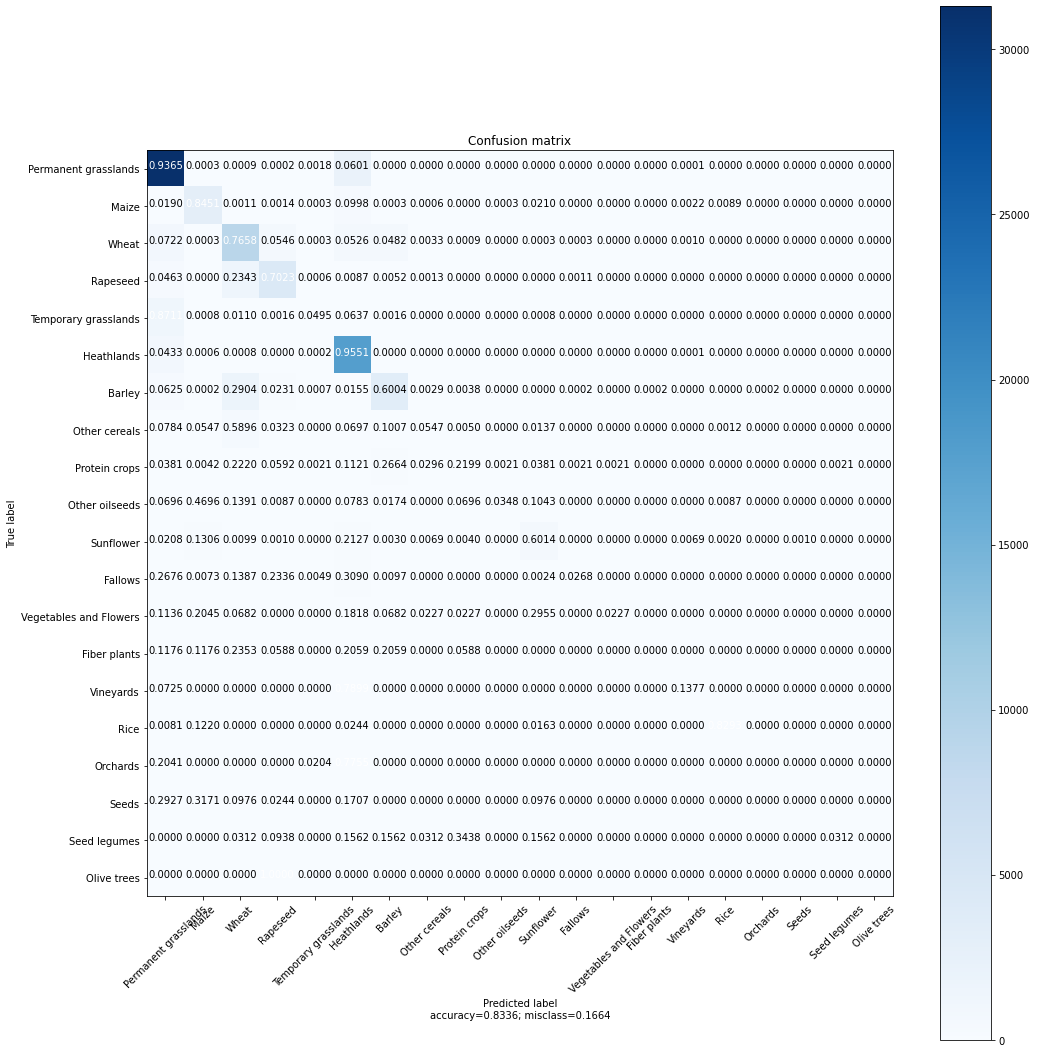

overall accuracy = 0.83, kappa = 0.78, precision = 0.52, recall=0.34, f1=0.36


In [ ]:
knn =KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)
pred=knn.predict(X_test)
lb.fit(y_test)
binary=lb.transform(y_test)
predF=lb.transform(pred)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm,labels)

###############################################################
metrics = confusion_matrix_to_accuraccies(cm)
overall_accuracy, kappa, precision, recall, f1, cl_acc = metrics
print(f"overall accuracy = {overall_accuracy:.2f}, kappa = {kappa:.2f}, precision = {precision.mean():.2f},",
      f"recall={recall.mean():.2f}, f1={f1.mean():.2f}")



In [ ]:
ReturnType={v:k for k,v in Type.items()}
table= PrettyTable()
test=list(y_test)
pred=list(map(lambda a:ReturnType[a],pred[:500:25]))
test=list(map(lambda a:ReturnType[a],test[:500:25]))
table.add_column("Actual_label",test)
table.add_column("Predicted_label",pred)
print(table)

+----------------------+----------------------+
|     Actual_label     |   Predicted_label    |
+----------------------+----------------------+
|        Wheat         |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|       Fallows        |       Rapeseed       |
| Permanent grasslands | Permanent grasslands |
|       Rapeseed       |       Rapeseed       |
| Permanent grasslands | Permanent grasslands |
|        Wheat         |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|      Heathlands      | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
|        Maize         |        Maize         |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
|        Wheat         |        Wheat   

# Support vector machine

In [ ]:
# best_C=0
# best_score=0
# lb=LabelBinarizer()
# lb.fit(y_cv)
# binary=lb.transform(y_cv)
# for c in range(-5,6,1):
#     clf = SVC(C=2**c,kernel='rbf',gamma='scale')
#     clf.fit(X_train,y_train)
#     pred=clf.predict(X_cv)
#     pred=lb.transform(pred)
#     score=roc_auc_score(binary,pred)
#     if best_score<=score:
#         best_C=c
#         best_score=score
# print("The optimal value for C is:",2**best_C)



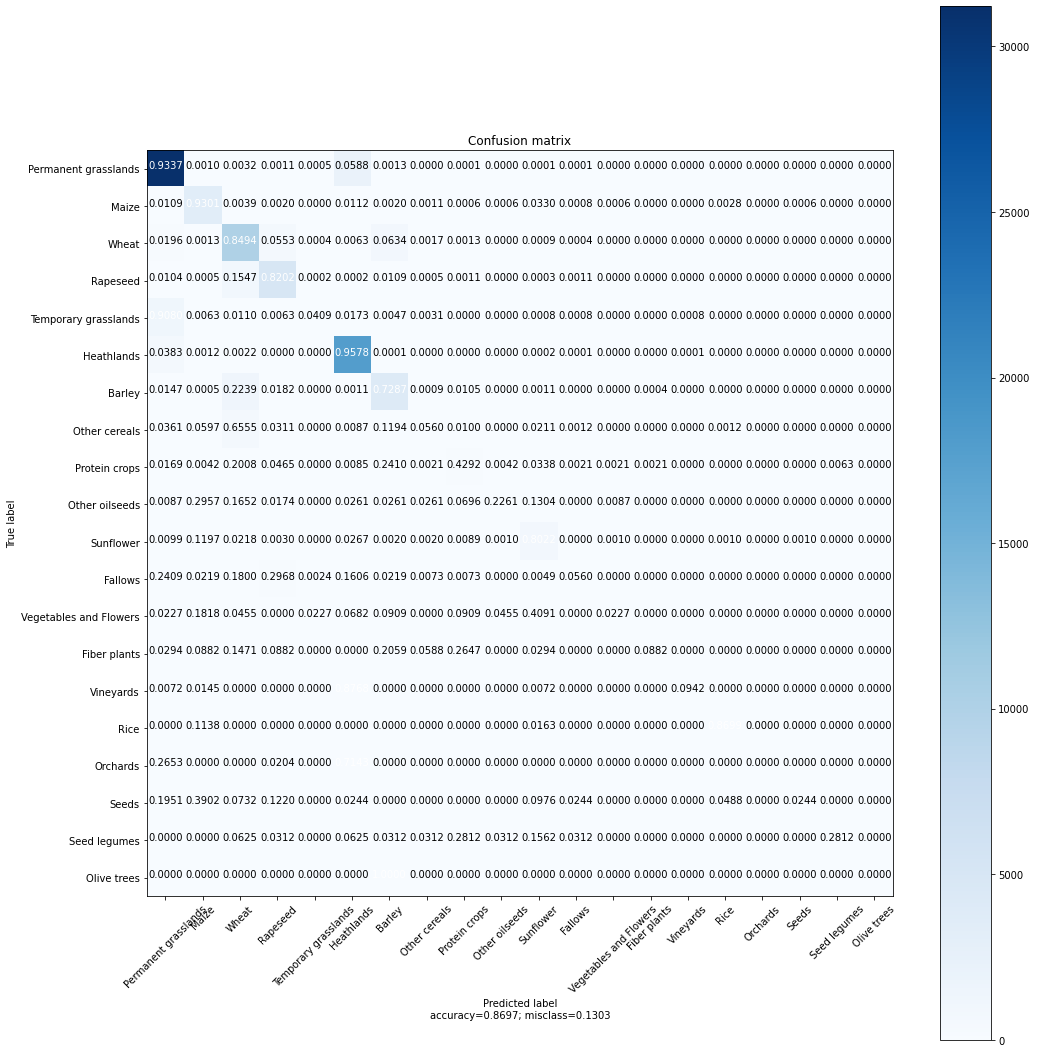

overall accuracy = 0.87, kappa = 0.83, precision = 0.61, recall=0.41, f1=0.44


In [ ]:
svm =SVC(C=32,gamma='scale',kernel='rbf')
svm.fit(X_train,y_train)
pred=svm.predict(X_test)
lb.fit(y_test)
binary=lb.transform(y_test)
predF=lb.transform(pred)
# score=roc_auc_score(binary,predF)
# print("The roc_auc_score is :",score)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm,labels)

###############################################################
metrics = confusion_matrix_to_accuraccies(cm)
overall_accuracy, kappa, precision, recall, f1, cl_acc = metrics
print(f"overall accuracy = {overall_accuracy:.2f}, kappa = {kappa:.2f}, precision = {precision.mean():.2f},",
      f"recall={recall.mean():.2f}, f1={f1.mean():.2f}")

In [ ]:
from sklearn.metrics import classification_report
# print(classification_report(y_test, pred,labels=20, target_names=labels))
print(classification_report(y_test,pred, target_names=labels))

                        precision    recall  f1-score   support

  Permanent grasslands       0.93      0.93      0.93     33422
                 Maize       0.91      0.93      0.92      3576
                 Wheat       0.76      0.85      0.80     11780
              Rapeseed       0.84      0.82      0.83      6175
  Temporary grasslands       0.68      0.04      0.08      1272
            Heathlands       0.88      0.96      0.92     18623
                Barley       0.79      0.73      0.76      5596
         Other cereals       0.48      0.06      0.10       804
         Protein crops       0.60      0.43      0.50       473
        Other oilseeds       0.76      0.23      0.35       115
             Sunflower       0.78      0.80      0.79      1011
               Fallows       0.50      0.06      0.10       411
Vegetables and Flowers       0.17      0.02      0.04        44
          Fiber plants       0.50      0.09      0.15        34
             Vineyards       0.81      

In [ ]:
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<ipython-input-77-d298b44ac470> in <module>()
      1 from sklearn.metrics import classification_report
      2 # print(classification_report(y_test, pred,labels=20, target_names=labels))
----> 3 print(classification_report(y_test,pred, target_names=labels))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py in classification_report(y_true, y_pred, labels, target_names, sample_weight, digits, output_dict, zero_division)
   1993                 "Number of classes, {0}, does not match size of "
   1994                 "target_names, {1}. Try specifying the labels "
-> 1995                 "parameter".format(len(labels), len(target_names))
   1996             )
   1997     if target_names is None:

ValueError: Number of classes, 19, does not match size of target_names, 20. Try specifying the labels parameter

SyntaxError: ignored

In [ ]:
table= PrettyTable()
test=list(y_test)
pred=list(map(lambda a:ReturnType[a],pred[0:100]))
test=list(map(lambda a:ReturnType[a],test[0:100]))
table.add_column("Actual_label",test)
table.add_column("Predicted_label",pred)
print(table)

+----------------------+----------------------+
|     Actual_label     |   Predicted_label    |
+----------------------+----------------------+
|        Wheat         |        Wheat         |
|       Rapeseed       |       Rapeseed       |
|      Heathlands      |      Heathlands      |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
|       Rapeseed       |       Rapeseed       |
|        Wheat         |        Wheat         |
|      Heathlands      |      Heathlands      |
| Permanent grasslands | Permanent grasslands |
|        Maize         |        Maize         |
|      Heathlands      |      Heathlands      |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
|      Heathlands      |      Heathlands      |
|      Heathlands      |      Heathlands      |
| Permanent grasslands | Permanent grass

# Decision tree

In [ ]:
# best_depth=0
# best_score=0
# lb=LabelBinarizer()
# lb.fit(y_cv)
# binary=lb.transform(y_cv)
# for d in range(2,21,2):
#     clf = DecisionTreeClassifier(max_depth=d, random_state=3457)
#     clf.fit(X_train,y_train)
#     pred=clf.predict(X_cv)
#     pred=lb.transform(pred)
#     score=roc_auc_score(binary,pred)
#     if best_score<=score:
#         best_depth=d
#         best_score=score
# print("The optimal depth is:",best_depth)

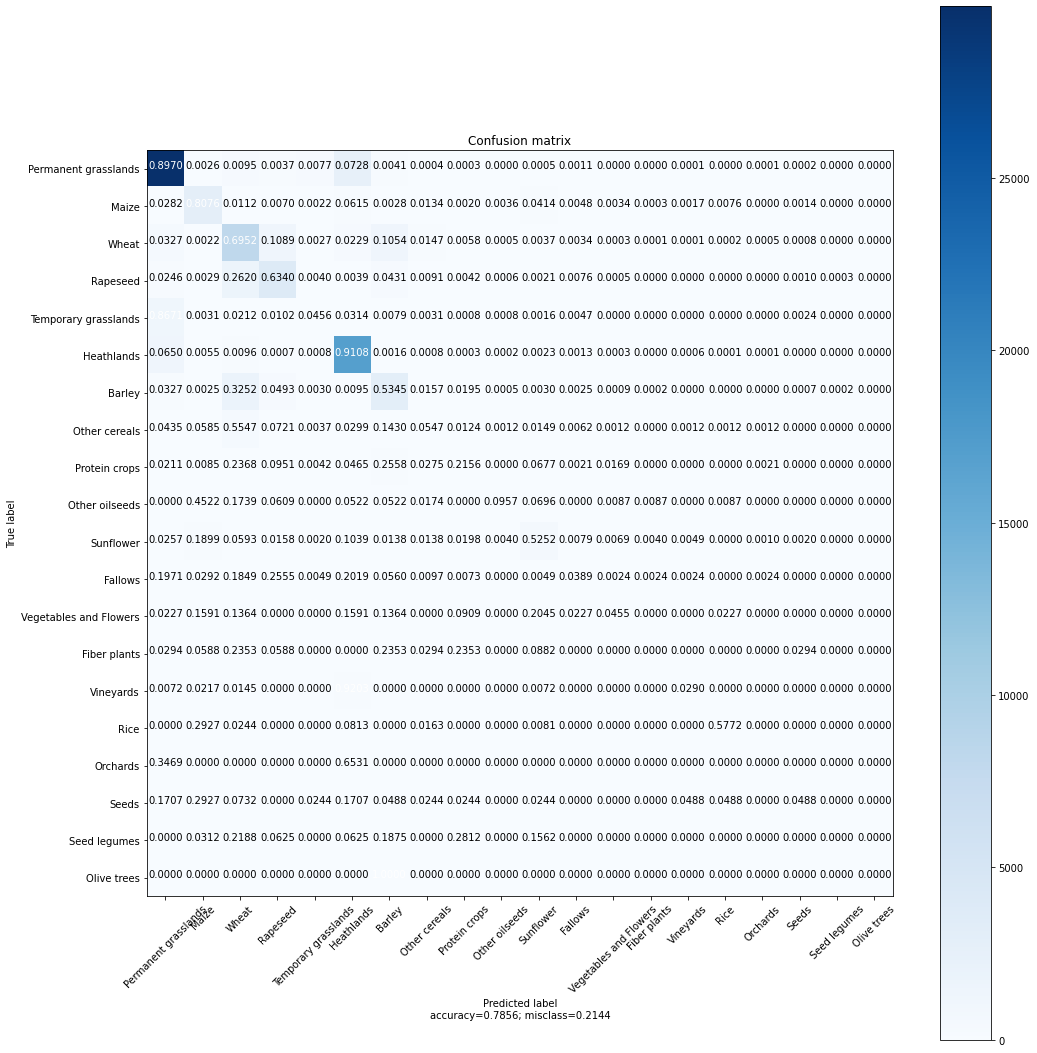

overall accuracy = 0.79, kappa = 0.72, precision = 0.34, recall=0.31, f1=0.32


In [ ]:
DT = DecisionTreeClassifier(max_depth=16, random_state=3457)
DT.fit(X_train,y_train)
pred=DT.predict(X_test)
lb.fit(y_test)
binary=lb.transform(y_test)
predF=lb.transform(pred)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm,labels)

###############################################################
metrics = confusion_matrix_to_accuraccies(cm)
overall_accuracy, kappa, precision, recall, f1, cl_acc = metrics
print(f"overall accuracy = {overall_accuracy:.2f}, kappa = {kappa:.2f}, precision = {precision.mean():.2f},",
      f"recall={recall.mean():.2f}, f1={f1.mean():.2f}")

In [ ]:
table= PrettyTable()
test=list(y_test)
pred=list(map(lambda a:ReturnType[a],pred[:500:25]))
test=list(map(lambda a:ReturnType[a],test[:500:25]))
table.add_column("Actual_label",test)
table.add_column("Predicted_label",pred)
print(table)


+----------------------+----------------------+
|     Actual_label     |   Predicted_label    |
+----------------------+----------------------+
|        Wheat         |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|       Fallows        |       Rapeseed       |
| Permanent grasslands | Permanent grasslands |
|       Rapeseed       |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|        Wheat         |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|      Heathlands      |      Heathlands      |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands |      Heathlands      |
|        Maize         |        Maize         |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands |        Barley        |
| Permanent grasslands | Permanent grasslands |
|        Wheat         |        Wheat   

# Random forest ensemble

In [ ]:
# best_depth=0
# best_score=0
# lb=LabelBinarizer()
# lb.fit(y_cv)
# binary=lb.transform(y_cv)
# for d in range(2,21,2):
#     clf = RandomForestClassifier(max_depth=d, random_state=3457,n_estimators=80)
#     clf.fit(X_train,y_train)
#     pred=clf.predict(X_cv)
#     pred=lb.transform(pred)
#     score=roc_auc_score(binary,pred)
#     if best_score<=score:
#         best_depth=d
#         best_score=score
# print("The optimal depth is:",best_depth)

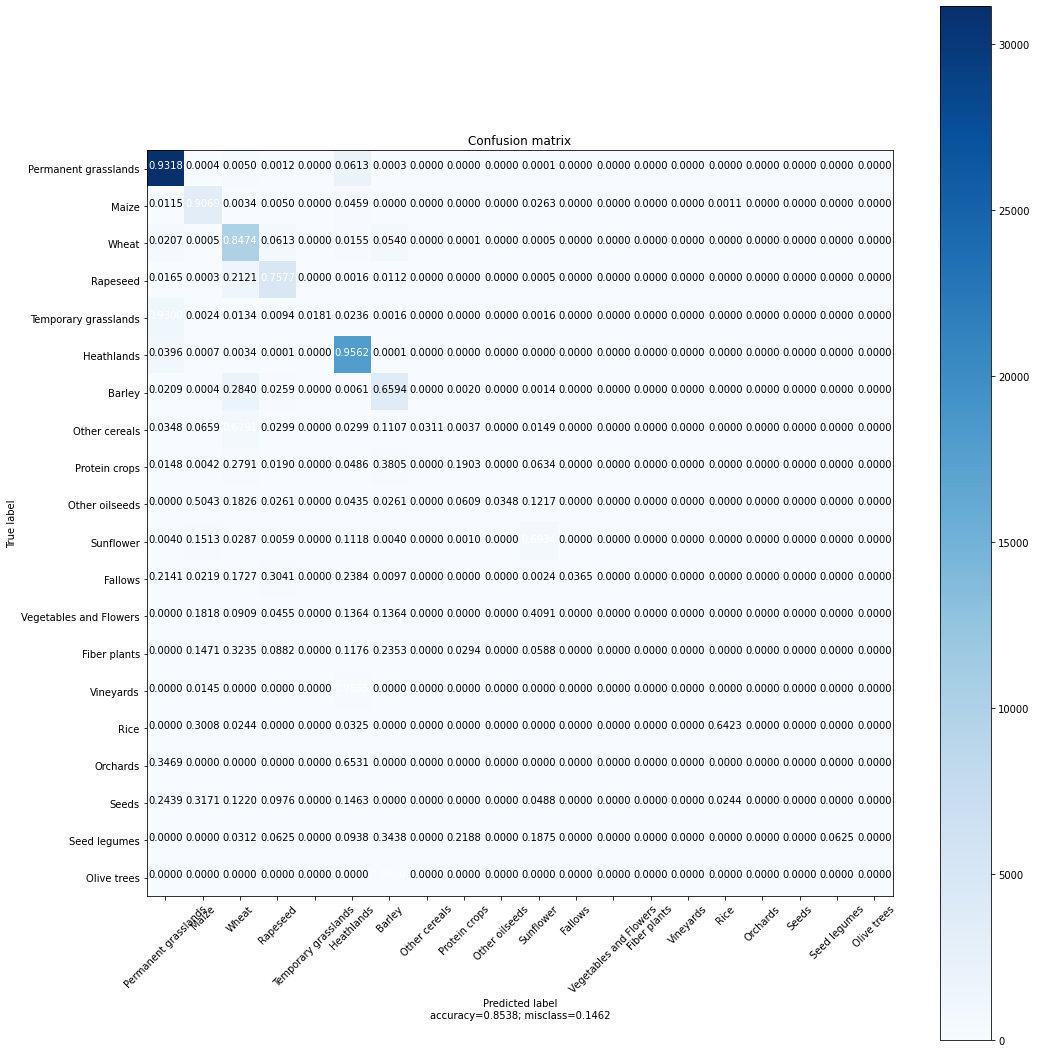

overall accuracy = 0.85, kappa = 0.81, precision = 0.62, recall=0.34, f1=0.36


In [ ]:
RF= RandomForestClassifier(max_depth=20, random_state=3457,n_estimators=80)
RF.fit(X_train,y_train)
pred=RF.predict(X_test)
lb.fit(y_test)
binary=lb.transform(y_test)
predF=lb.transform(pred)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm,labels)

###############################################################
metrics = confusion_matrix_to_accuraccies(cm)
overall_accuracy, kappa, precision, recall, f1, cl_acc = metrics
print(f"overall accuracy = {overall_accuracy:.2f}, kappa = {kappa:.2f}, precision = {precision.mean():.2f},",
      f"recall={recall.mean():.2f}, f1={f1.mean():.2f}")

In [ ]:
table= PrettyTable()
test=list(y_test)
pred=list(pred)
predT=list(map(lambda a:ReturnType[a],pred[:500:25]))
testT=list(map(lambda a:ReturnType[a],test[:500:25]))
table.add_column("Actual_label",testT)
table.add_column("Predicted_label",predT)
print(table)

+----------------------+----------------------+
|     Actual_label     |   Predicted_label    |
+----------------------+----------------------+
|        Wheat         |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|       Fallows        |       Rapeseed       |
| Permanent grasslands | Permanent grasslands |
|       Rapeseed       |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|        Wheat         |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|      Heathlands      |      Heathlands      |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands |      Heathlands      |
|        Maize         |        Maize         |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
|        Wheat         |        Wheat   

# Accracy of individual crop

In [ ]:
from collections import defaultdict
predCount=defaultdict(int)
for i in range(len(pred)):
    if pred[i]==test[i]:
        predCount[pred[i]]+=1
for ele in data['ID'].unique():
    predCount[ele]/=test.count(ele)
x=[]
y=[]
for i ,j in dict(predCount).items():
    x.append(ReturnType[i])
    y.append(j*100)

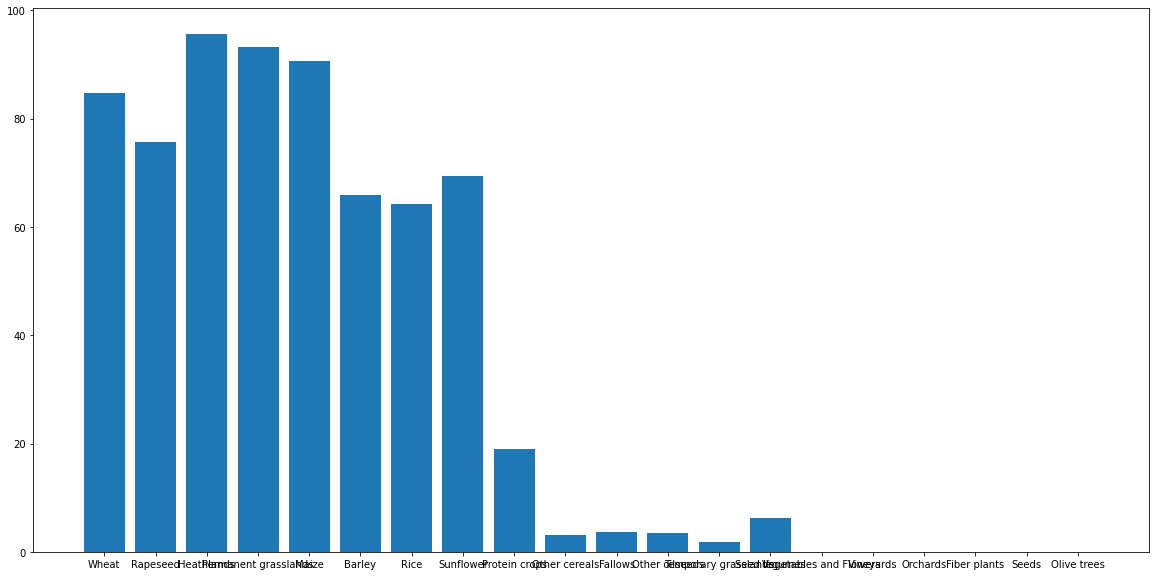

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(x,y)
plt.show()

In [ ]:
table= PrettyTable()
model=x
AUC=y
table.add_column("Crop_Type",x)
table.add_column("Accuracy",list(map(lambda x:round(x,2),y)))
print(table)

+------------------------+----------+
|       Crop_Type        | Accuracy |
+------------------------+----------+
|         Wheat          |  84.74   |
|        Rapeseed        |  75.77   |
|       Heathlands       |  95.62   |
|  Permanent grasslands  |  93.18   |
|         Maize          |  90.69   |
|         Barley         |  65.94   |
|          Rice          |  64.23   |
|       Sunflower        |  69.34   |
|     Protein crops      |  19.03   |
|     Other cereals      |   3.11   |
|        Fallows         |   3.65   |
|     Other oilseeds     |   3.48   |
|  Temporary grasslands  |   1.81   |
|      Seed legumes      |   6.25   |
| Vegetables and Flowers |   0.0    |
|       Vineyards        |   0.0    |
|        Orchards        |   0.0    |
|      Fiber plants      |   0.0    |
|         Seeds          |   0.0    |
|      Olive trees       |   0.0    |
+------------------------+----------+


# SGD classifier

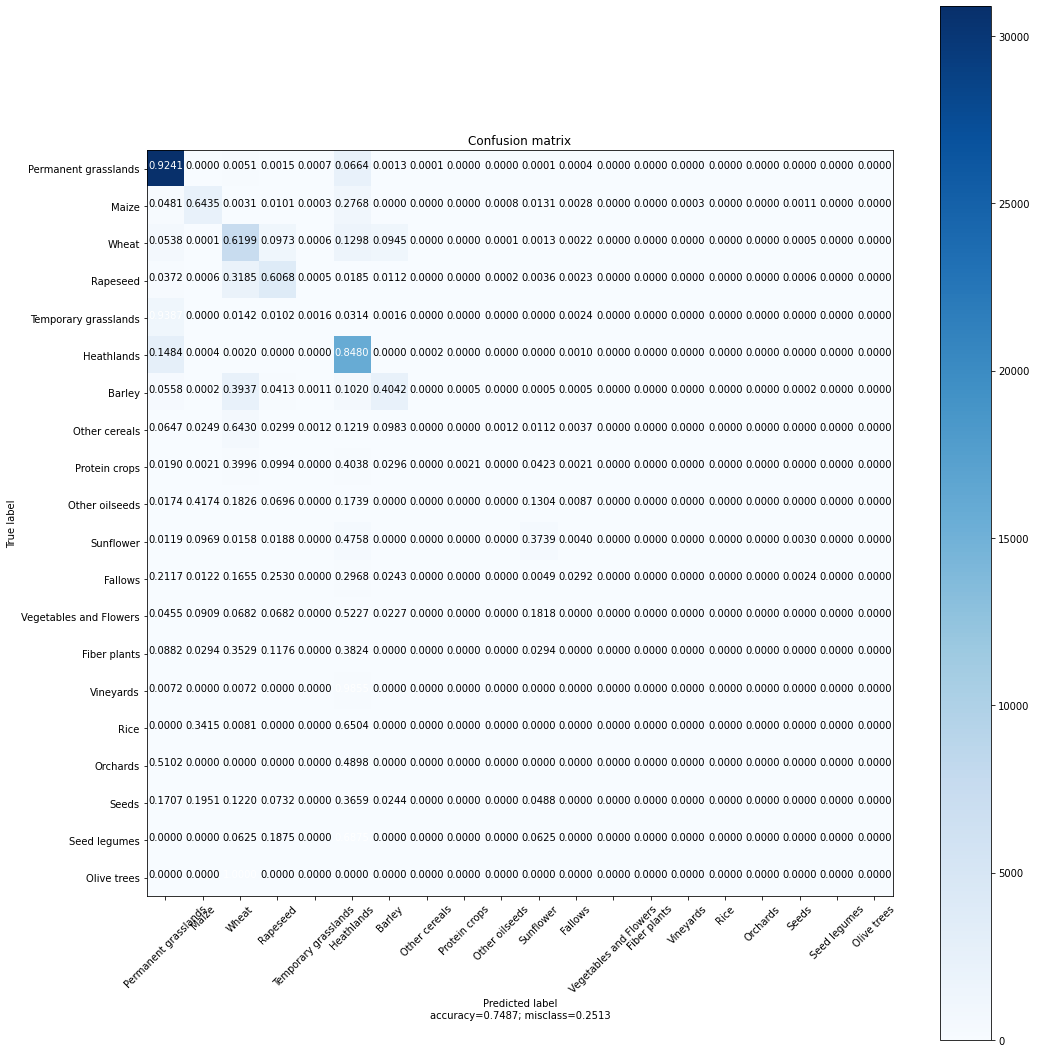

overall accuracy = 0.75, kappa = 0.66, precision = 0.27, recall=0.22, f1=0.23


In [ ]:
clf = SGDClassifier(max_iter=10000, tol=1e-3)
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
lb.fit(y_test)
binary=lb.transform(y_test)
predF=lb.transform(pred)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm,labels)

###############################################################
metrics = confusion_matrix_to_accuraccies(cm)
overall_accuracy, kappa, precision, recall, f1, cl_acc = metrics
print(f"overall accuracy = {overall_accuracy:.2f}, kappa = {kappa:.2f}, precision = {precision.mean():.2f},",
      f"recall={recall.mean():.2f}, f1={f1.mean():.2f}")

# MLP classifier

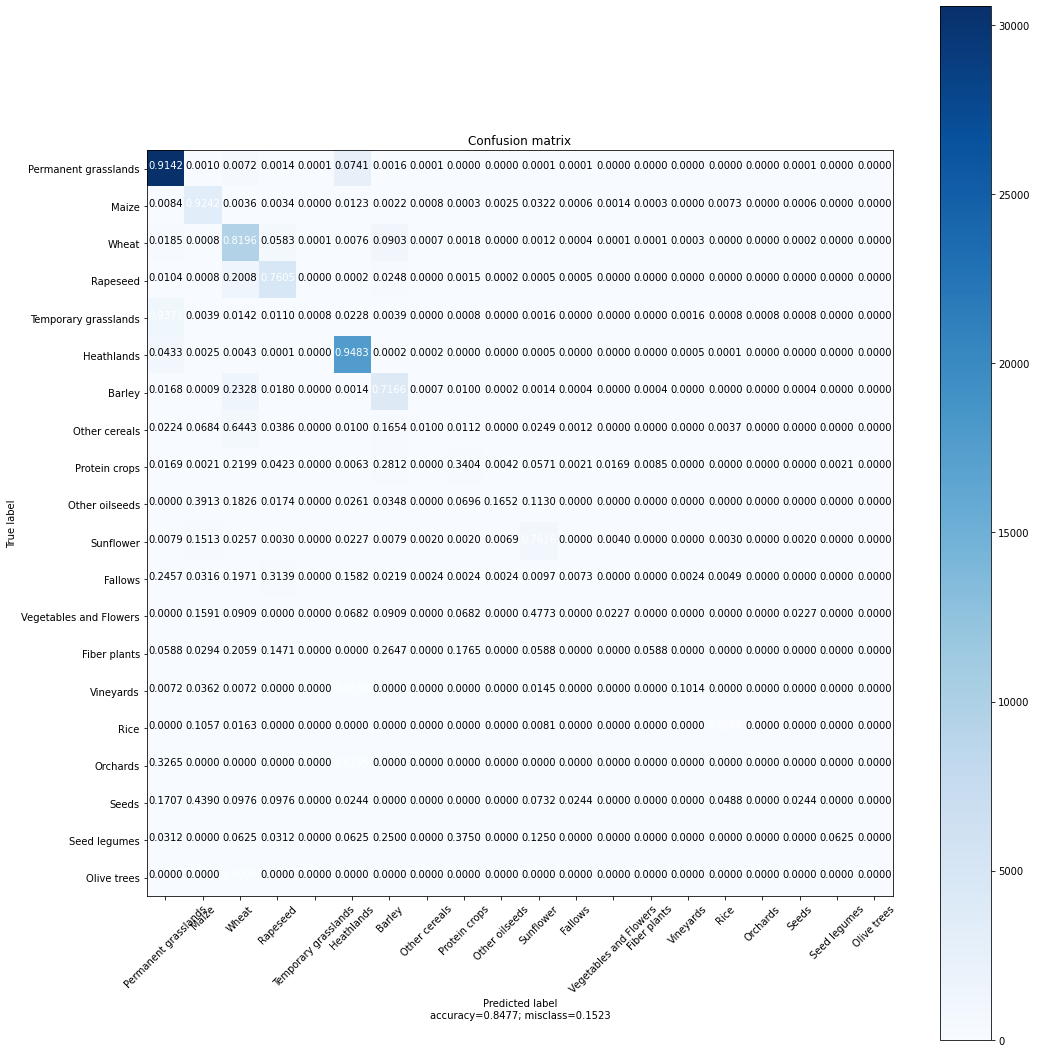

overall accuracy = 0.85, kappa = 0.80, precision = 0.47, recall=0.38, f1=0.38


In [ ]:
clf = MLPClassifier(random_state=1, max_iter=300)
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
lb.fit(y_test)
binary=lb.transform(y_test)
predF=lb.transform(pred)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm,labels)

###############################################################
metrics = confusion_matrix_to_accuraccies(cm)
overall_accuracy, kappa, precision, recall, f1, cl_acc = metrics
print(f"overall accuracy = {overall_accuracy:.2f}, kappa = {kappa:.2f}, precision = {precision.mean():.2f},",
      f"recall={recall.mean():.2f}, f1={f1.mean():.2f}")

In [ ]:
table= PrettyTable()
test=list(y_test)
pred=list(pred)
predT=list(map(lambda a:ReturnType[a],pred[:500:25]))
testT=list(map(lambda a:ReturnType[a],test[:500:25]))
table.add_column("Actual_label",testT)
table.add_column("Predicted_label",predT)
print(table)

+----------------------+----------------------+
|     Actual_label     |   Predicted_label    |
+----------------------+----------------------+
|        Wheat         |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|       Fallows        |       Rapeseed       |
| Permanent grasslands | Permanent grasslands |
|       Rapeseed       |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|        Wheat         |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|      Heathlands      |      Heathlands      |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands |      Heathlands      |
|        Maize         |        Maize         |
| Permanent grasslands | Permanent grasslands |
| Permanent grasslands |        Wheat         |
| Permanent grasslands | Permanent grasslands |
|        Wheat         |        Wheat   

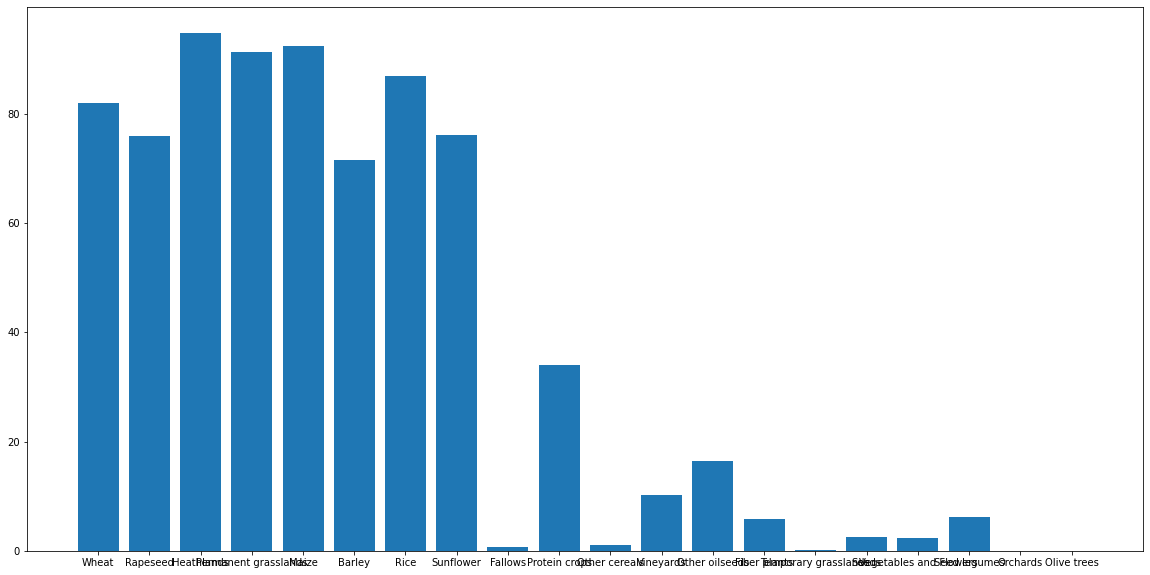

In [ ]:
from collections import defaultdict
predCount=defaultdict(int)
for i in range(len(pred)):
    if pred[i]==test[i]:
        predCount[pred[i]]+=1
for ele in data['ID'].unique():
    predCount[ele]/=test.count(ele)
x=[]
y=[]
for i ,j in dict(predCount).items():
    x.append(ReturnType[i])
    y.append(j*100)

plt.figure(figsize=(20,10))
plt.bar(x,y)
plt.show()

In [ ]:
table= PrettyTable()
model=x
AUC=y
table.add_column("Crop_Type",x)
table.add_column("Accuracy",list(map(lambda x:round(x,2),y)))
print(table)

+------------------------+----------+
|       Crop_Type        | Accuracy |
+------------------------+----------+
|         Wheat          |  81.96   |
|        Rapeseed        |  76.05   |
|       Heathlands       |  94.83   |
|  Permanent grasslands  |  91.42   |
|         Maize          |  92.42   |
|         Barley         |  71.66   |
|          Rice          |  86.99   |
|       Sunflower        |  76.16   |
|        Fallows         |   0.73   |
|     Protein crops      |  34.04   |
|     Other cereals      |   1.0    |
|       Vineyards        |  10.14   |
|     Other oilseeds     |  16.52   |
|      Fiber plants      |   5.88   |
|  Temporary grasslands  |   0.08   |
|         Seeds          |   2.44   |
| Vegetables and Flowers |   2.27   |
|      Seed legumes      |   6.25   |
|        Orchards        |   0.0    |
|      Olive trees       |   0.0    |
+------------------------+----------+


# XGboost classifier

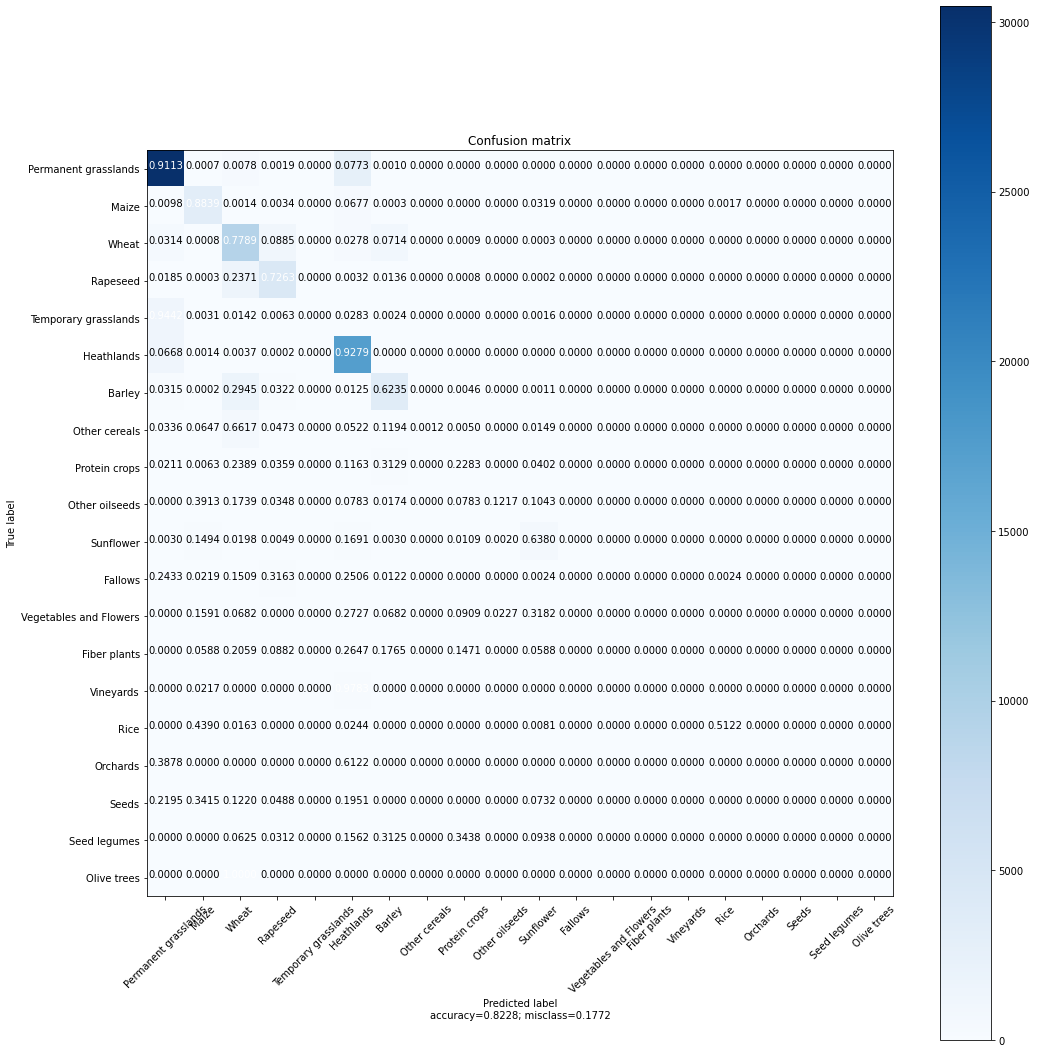

overall accuracy = 0.82, kappa = 0.76, precision = 0.44, recall=0.32, f1=0.33


In [ ]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(X_train,y_train)
pred=clf.predict(X_test)
lb.fit(y_test)
binary=lb.transform(y_test)
predF=lb.transform(pred)
cm = confusion_matrix(y_test, pred)
plot_confusion_matrix(cm,labels)

###############################################################
metrics = confusion_matrix_to_accuraccies(cm)
overall_accuracy, kappa, precision, recall, f1, cl_acc = metrics
print(f"overall accuracy = {overall_accuracy:.2f}, kappa = {kappa:.2f}, precision = {precision.mean():.2f},",
      f"recall={recall.mean():.2f}, f1={f1.mean():.2f}")

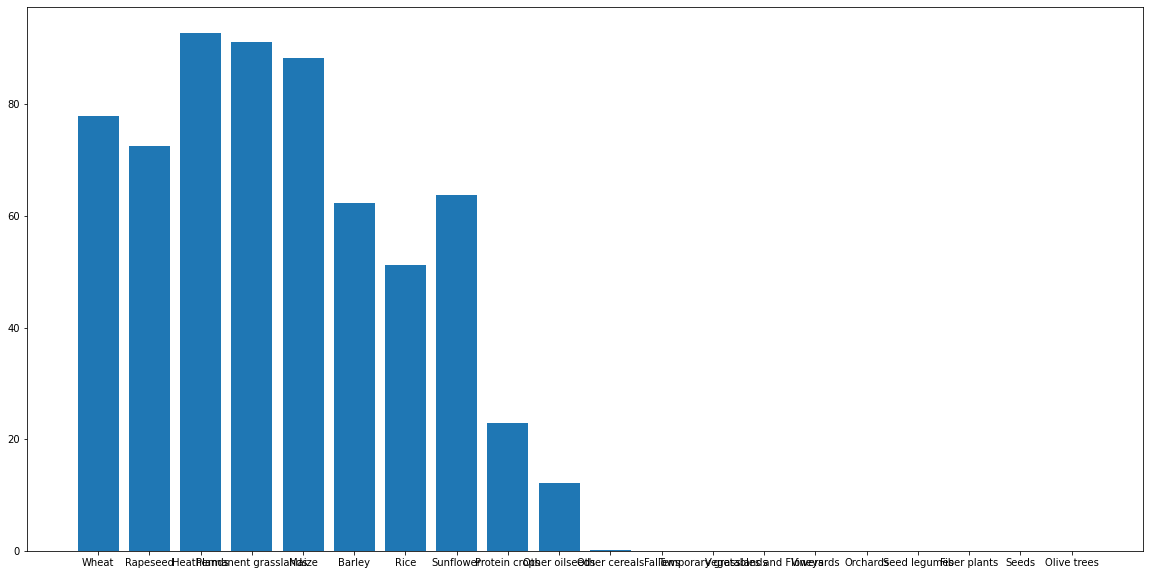

In [ ]:
from collections import defaultdict
predCount=defaultdict(int)
for i in range(len(pred)):
    if pred[i]==test[i]:
        predCount[pred[i]]+=1
for ele in data['ID'].unique():
    predCount[ele]/=test.count(ele)
x=[]
y=[]
for i ,j in dict(predCount).items():
    x.append(ReturnType[i])
    y.append(j*100)      
plt.figure(figsize=(20,10))
plt.bar(x,y)
plt.show()

In [ ]:
table= PrettyTable()
model=x
AUC=y
table.add_column("Crop_Type",x)
table.add_column("Accuracy",list(map(lambda x:round(x,2),y)))
print(table)

+------------------------+----------+
|       Crop_Type        | Accuracy |
+------------------------+----------+
|         Wheat          |  77.89   |
|        Rapeseed        |  72.63   |
|       Heathlands       |  92.79   |
|  Permanent grasslands  |  91.13   |
|         Maize          |  88.39   |
|         Barley         |  62.35   |
|          Rice          |  51.22   |
|       Sunflower        |   63.8   |
|     Protein crops      |  22.83   |
|     Other oilseeds     |  12.17   |
|     Other cereals      |   0.12   |
|        Fallows         |   0.0    |
|  Temporary grasslands  |   0.0    |
| Vegetables and Flowers |   0.0    |
|       Vineyards        |   0.0    |
|        Orchards        |   0.0    |
|      Seed legumes      |   0.0    |
|      Fiber plants      |   0.0    |
|         Seeds          |   0.0    |
|      Olive trees       |   0.0    |
+------------------------+----------+


# comparison between models

In [ ]:
# table= PrettyTable()
# model=['KNN','Support Vector Machine','Decision Tree','Random Forest']
# AUC=[0.94259,0.96018,0.95555,0.96574]
# table.add_column("Model",model)
# table.add_column("AUC",AUC)
# print(table)

# saving the model to drive

In [ ]:
# dump(RF, '/content/drive/My Drive/CropPredictRF.joblib')
# dump(scaler,'/content/drive/My Drive/CropScaler.joblib')